###### <img width=200 src="ENSL.svg"/> 
author: Aurélien Garivier

# Dimension reduction for the MNIST dataset


The Mnist dataset provides a (somewhat old but) very classical example of Machine Learning. The goal is simple and useful: recognize hand-written digits. This was an important challenge for the postal companies in the 1980s.  

It is available in sklearn (and on the webpage of <a href="http://yann.lecun.com/exdb/mnist/">Yann LeCun</a>, a very famous researcher in Machine Learning in general and neural networks in particular). 

</p>

In [2]:
# loading a lot of facilities for numerical computations and graphs
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 6) # to have larger plot
seed(240979) #initialize random number generator

# set working directory
workingdir = './'

Populating the interactive namespace from numpy and matplotlib


## 1. Loading the data set

### 1.1 Description of the data set
The MNIST data contains $n\_tot=70000$ images of size $dimX\times dimY=28\times28$, and their *labels* (a digit between $0$ and $9$). 
The images are stored as lines of the matrix *mnist.data*. 
Each image can be reshaped as a matrix $im \in \mathcal{M}_{dimX, dimY}(\mathbb{R})$, where $im[i,j]$ is the intensity level of pixel (i,j): 0 means 'white', 255 means 'black'.

The labels, stored in *mnist.target*, are numbers (here, we cast them to integers) between $0$ and $9$. 

In [5]:
# from sklearn.datasets import fetch_mldata # si besoin: sudo pip install -U scikit-learn ou (pour une install locale)  pip install --user --install-option="--prefix=" -U scikit-learn
# mnist = fetch_mldata('MNIST original')#, data_home='./')
# mnist.target = mnist.target.astype(int) # by default the digits are floating numbers: convert to integers

from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# defining general variables for use throuhout the notebook  
ntot, p = shape(mnist.data)
dimX = int(sqrt(p))
dimY = dimX 
nc = len(unique(y)) # number of classes

print("Loaded %d images of size %dx%d"%(n_tot, dimX, dimY))
print("Number of classes: %d"%(nc))
print("Classes:")
print(sorted(unique(mnist.target)))

Loaded 70000 images of size 28x28
Number of classes: 10
Classes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### 1.2 What does the data look like?

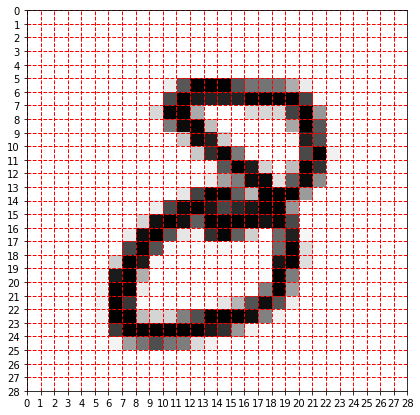

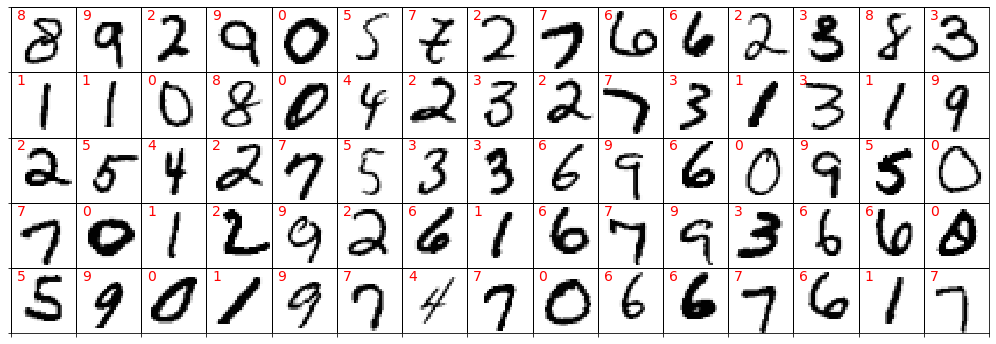

In [7]:
# Showing one image 
figure(figsize = (7,7))
ii = random.randint(0, n_tot-1)
plt.imshow(reshape(X[ii], [dimX, dimY], order='C'), cmap="Greys", interpolation="none") # or "nearest"
ax = plt.gca()
ax.set_xticks(arange(-0.5, dimX, 1))
ax.set_yticks(arange(-0.5, dimY, 1))
ax.set_xticklabels(arange(0, dimX+1, 1))
ax.set_yticklabels(arange(0, dimY+1, 1))
ax.grid(color='r', linestyle='--', linewidth=1)
plt.show()

# Showing a few images in the dataset with their labels
nbRows = 5
nbCols = 15
I = [[0 for k in range(nbCols)] for j in range(nbRows)]
I[0] = [random.randint(0, n_tot-1) for k in range(nbCols)]
I[0][0] = ii
M = np.concatenate([reshape(X[i], [dimX,dimY], order='C') for i in I[0]], axis=1)

for j in range(1, nbRows):
    I[j] = [random.randint(0, n_tot-1) for k in range(nbCols)]
    M = concatenate([M, np.concatenate([np.reshape(X[i], [dimX, dimY], order='C') for i in I[j]], axis=1)], axis=0)
plt.imshow(M, cmap="Greys", interpolation="none")
for j in range(nbRows):
    for k in range(nbCols):
        plt.text(dimX*k+2, dimX*j+5, y[I[j][k]], fontsize=14, color="red")
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, dimX*nbCols, dimX))
ax.set_yticks(np.arange(-0.5, dimY*nbRows, dimY))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(color='k', linestyle='-', linewidth=1)

## Nearest-neighbor classifier
Distance-based methods consider some notion of *distance* in the feature space, and assume that if to feature vectors are close, then the corresponding targets are likely to be equal.

### 7.1 What distance?
The first problem, of course, is to provide the feature space with a relevant distance. There are a few default choices, and in particular the Euclidian distance (o $L^2$ distance) in $\mathbb{R}^p$ :
$$d(x,y) = \sqrt{\sum_{i=1}^p (x_i-y_i)^2}$$

Is this distance really relevant on images? 
A better alternative would be the *earthmoving distance*, but it is much more costly in computation time and we will see that the $L^2$ distance already performs well.


If you code it by yourself, the result will be good butthe computation time ridiculously high...

The classifiers of scikitlearn are usually well coded, and much more efficient than a few "quick and dirty" lines.



In [8]:
import time

n_train = 10000
I = random.choice(range(n_tot), n_train, replace=False)
trainingX = X[I, :] 
trainingTarget = y[I]

# testing set: we may not use them, except at the end to assert the quality of the classifier
mask = np.ones(n_tot, dtype=bool) #np.ones_like(a,dtype=bool)
mask[I] = False
testingX = X[mask, :]
testingTarget = y[mask]

from sklearn.neighbors import KNeighborsClassifier
k = 7
nearestNeighborsClassifier = KNeighborsClassifier(n_neighbors=k) # L2 distance is the default
nearestNeighborsClassifier.fit(trainingX, trainingTarget)

J = random.choice(range(len(testingTarget)), 5000, replace=False)

start_time = time.time()
pred = nearestNeighborsClassifier.predict(testingX[J])
print("Proportion of misclassified images in testing set: %g" %(mean(pred != testingTarget[J])))
print("elapsed: %g seconds"%(time.time()-start_time))

Proportion of misclassified images in testing set: 0.0546
elapsed: 70.8708 seconds


# Using PCA to reduce dimensionality

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
trainingXred = pca.fit_transform(trainingX)

nearestNeighborsClassifierRed = KNeighborsClassifier(n_neighbors=k) # L2 distance is the default
nearestNeighborsClassifierRed.fit(trainingXred, trainingTarget)


testingXred = pca.transform(testingX)
start_time = time.time()
predRed = nearestNeighborsClassifierRed.predict(testingXred[J])
print("PCA projection: Proportion of misclassified images in testing set: %g" %(mean(predRed != testingTarget[J])))
print("elapsed: %g seconds"%(time.time()-start_time))



PCA projection: Proportion of misclassified images in testing set: 0.0566
elapsed: 0.625063 seconds


# Using Random Projections to reduce dimensionality


In [10]:
d = 50
W = random.normal(0, 1/sqrt(d), dimX*dimY*d).reshape((d, dimX*dimY))
trainingXrproj = [dot(W, x) for x in trainingX]

nearestNeighborsClassifierRproj = KNeighborsClassifier(n_neighbors=k) # L2 distance is the default
nearestNeighborsClassifierRproj.fit(trainingXrproj, trainingTarget)


testingXrproj = np.array([dot(W, x) for x in testingX])
start_time = time.time()
predRproj = nearestNeighborsClassifierRproj.predict(testingXrproj[J])
print("Random projection: Proportion of misclassified images in testing set: %g" %(mean(predRproj != testingTarget[J])))
print("elapsed: %g seconds"%(time.time()-start_time))



Random projection: Proportion of misclassified images in testing set: 0.0972
elapsed: 3.93394 seconds


## Questions

### Q1. Plot the main eigenvectors (as images) and try to interpret them.

### Q2. For both PCA and random projections, plot the estimated classification performance as a function of the dimension $d$ in the projected space. Comment.

### Q3. You are given the same time budget required for the prediction of ntest=5000 examples with the k-nearest neighbors computed on n=10000 examples above. You must still use the same classifier, but you may use more examples in the training set and use dimensionality reduction. Can you improve the prediction performance?

### Q4. Try to use some non-Gaussian law for the random projection. When do you observe similar results, when not?